In [1]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from datetime import datetime, timedelta
from src.indicators.sma import calculate_sma
from pymongo import MongoClient
import json

In [17]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [18]:
db = client["forex_data"]
collections = db.list_collection_names()

In [19]:
# Choose a collection (for example EUR_USD_H1)
collection_name = "EUR_USD_H1"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_H1 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_H1.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_H1["open"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_H1["high"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_H1["low"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_H1["close"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_H1 = df_EURUSD_H1[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_H1)}")
print("\nFirst few rows:")
print(df_EURUSD_H1.head())


DataFrame info for EUR_USD_H1:
Total number of candles: 62153

First few rows:
                     volume     open     high      low    close
time                                                           
2025-02-11 03:00:00    2889  1.02932  1.03006  1.02922  1.02983
2025-02-11 04:00:00    3066  1.02982  1.03044  1.02976  1.03043
2025-02-11 05:00:00    2909  1.03044  1.03060  1.03022  1.03047
2025-02-11 06:00:00    4099  1.03047  1.03106  1.03042  1.03052
2025-02-11 07:00:00    5672  1.03052  1.03080  1.03010  1.03033


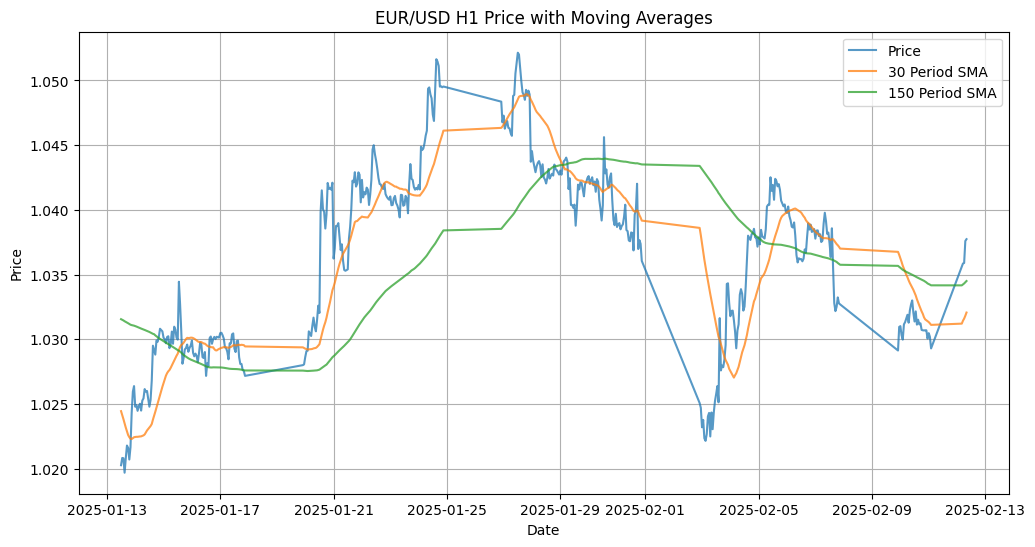

In [27]:
# Calculate moving averages
df_EURUSD_H1["SMA_30"] = calculate_sma(df_EURUSD_H1["close"], [30])[
    "sma_30"
]  # Pass period as a list
df_EURUSD_H1["SMA_150"] = calculate_sma(df_EURUSD_H1["close"], [150])[
    "sma_150"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_H1.index[-500:], df_EURUSD_H1["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD H1 Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
import numpy as np
import pandas as pd


def identify_multiple_ma_crossovers(df, ma_pairs):
    """
    Identify MA crossover signals for multiple MA combinations.
    """
    df = df.copy()
    signal_dfs = []  # To collect each signal column at once

    for fast, slow in ma_pairs:
        sma_fast = df["close"].rolling(window=fast).mean()
        sma_slow = df["close"].rolling(window=slow).mean()

        signal = np.where(
            (sma_fast > sma_slow) & (sma_fast.shift(1) <= sma_slow.shift(1)),
            1,  # Buy signal
            np.where(
                (sma_fast < sma_slow) & (sma_fast.shift(1) >= sma_slow.shift(1)),
                -1,  # Sell signal
                0,  # No signal
            ),
        )

        signal_col = f"signal_{fast}_{slow}"
        signal_df = pd.DataFrame({signal_col: signal}, index=df.index)
        signal_dfs.append(signal_df)

    # Concatenate all new signal columns once
    signals_concat = pd.concat(signal_dfs, axis=1)
    df = pd.concat([df, signals_concat], axis=1)
    return df


# Example usage:
ma_pairs = [(200, 50), (50, 200)]


# Apply to your DataFrame
df_with_signals = identify_multiple_ma_crossovers(df_EURUSD_H1, ma_pairs)

# Print columns with signals
signal_columns = [col for col in df_with_signals.columns if col.startswith("signal_")]
print("\nSignal columns created:")
for col in signal_columns:
    print(f"- {col}")

# Example: Count signals for each MA pair
for col in signal_columns:
    buy_signals = (df_with_signals[col] == 1).sum()
    sell_signals = (df_with_signals[col] == -1).sum()
    print(f"\n{col}:")
    print(f"Buy signals: {buy_signals}")
    print(f"Sell signals: {sell_signals}")


Signal columns created:
- signal_200_50
- signal_50_200

signal_200_50:
Buy signals: 199
Sell signals: 198

signal_50_200:
Buy signals: 198
Sell signals: 199


In [52]:
def backtest_multiple_signals(df, signal_columns, stop_loss_pips=50):
    results = {}

    for signal_col in signal_columns:
        trades = []
        open_trade = None
        df_temp = df.copy()

        for time, row in df_temp.iterrows():
            signal = row[signal_col]
            price = row["close"]

            if signal != 0:
                if open_trade is None:
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }
                elif signal != open_trade["signal"]:
                    exit_price = price
                    exit_time = time
                    if open_trade["signal"] == 1:
                        pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                    else:
                        pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                    trade = {
                        "entry_time": open_trade["entry_time"],
                        "exit_time": exit_time,
                        "entry_price": open_trade["entry_price"],
                        "exit_price": exit_price,
                        "signal": open_trade["signal"],
                        "pip_gain": pip_gain,
                    }
                    trades.append(trade)
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }

        # Close any open trade at the end of the data
        if open_trade is not None:
            last_time = df_temp.index[-1]
            last_price = df_temp.iloc[-1]["close"]
            if open_trade["signal"] == 1:
                pip_gain = (last_price - open_trade["entry_price"]) * 10000
            else:
                pip_gain = (open_trade["entry_price"] - last_price) * 10000
            trade = {
                "entry_time": open_trade["entry_time"],
                "exit_time": last_time,
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
            trades.append(trade)

        # Convert list of trades to a DataFrame
        results[signal_col] = pd.DataFrame(trades)
    return results


# Run backtest for all MA combinations
results = backtest_multiple_signals(df_with_signals, signal_columns)

# Print summary of results for each MA combination
print("\nBacktest Results Summary:")
print("-" * 80)
summary_data = []
for ma_combo, trades_df in results.items():
    num_trades = trades_df.shape[0]
    total_pips = trades_df["pip_gain"].sum()
    avg_pips = trades_df["pip_gain"].mean() if num_trades > 0 else 0
    win_rate = (trades_df["pip_gain"] > 0).mean() if num_trades > 0 else 0

    summary_data.append(
        {
            "MA_Combo": ma_combo,
            "Total_Trades": num_trades,
            "Total_Pips": total_pips,
            "Avg_Pips": avg_pips,
            "Win_Rate": win_rate,
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df)


Backtest Results Summary:
--------------------------------------------------------------------------------
        MA_Combo  Total_Trades  Total_Pips  Avg_Pips  Win_Rate
0  signal_200_50           397      2164.0  5.450882  0.662469
1  signal_50_200           397     -2164.0 -5.450882  0.337531


In [53]:
def calculate_atr(df, period=14):
    """
    Calculate Average True Range (ATR)

    Parameters:
    - df: DataFrame with high, low, close prices
    - period: Period for ATR calculation, default 14

    Returns:
    - Series containing ATR values
    """
    df = df.copy()

    # Calculate True Range
    df["tr1"] = df["high"] - df["low"]
    df["tr2"] = abs(df["high"] - df["close"].shift(1))
    df["tr3"] = abs(df["low"] - df["close"].shift(1))

    df["tr"] = df[["tr1", "tr2", "tr3"]].max(axis=1)

    # Calculate ATR
    atr = df["tr"].rolling(window=period).mean()

    return atr


Realistic Backtest Results:
Total Trades: 397
Total Pips: 145.0
Average Pips per Trade: 0.4
Win Rate: 37.0%
Sharpe Ratio: 0.52

Exit Analysis:
----------------------------------------
Exit Type Distribution:
sl: 250 trades (0.0% win rate)
tp: 147 trades (100.0% win rate)

Risk Metrics:
----------------------------------------
Profit Factor: 1.08
Maximum Drawdown: 213.9 pips


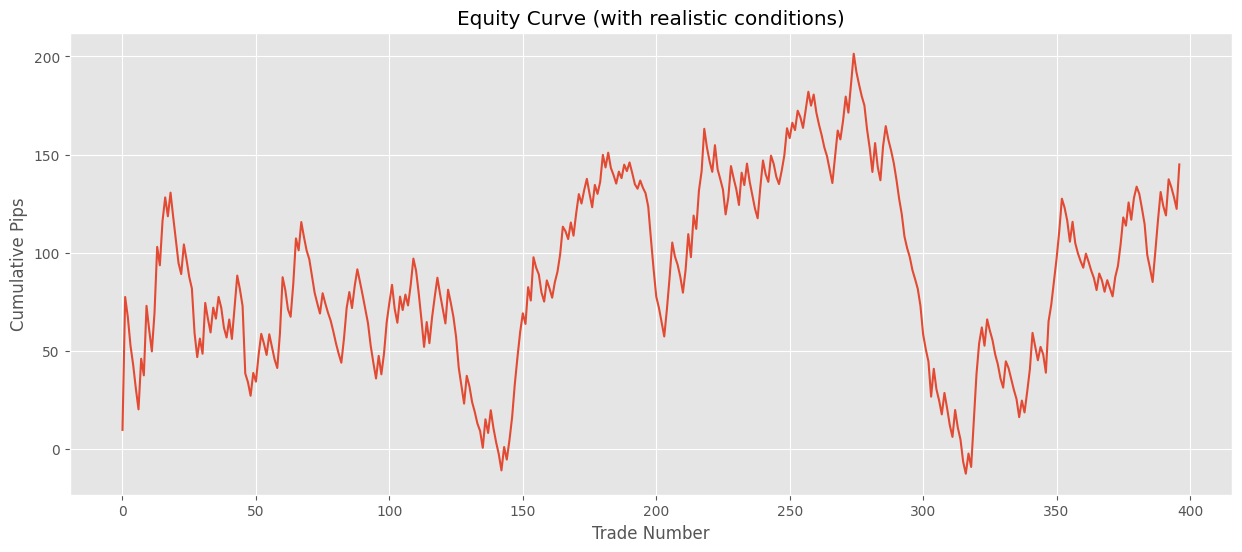

In [54]:
def realistic_backtest_with_risk_management(
    df, signal_col, spread_pips=1.0, tp_atr=1.0, sl_atr=0.5, atr_period=14
):
    """
    Add ATR-based stops and targets to realistic backtest
    """
    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        # Handle open trade
        if open_trade is not None:
            # Calculate take-profit and stop-loss levels
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] - (current_atr * sl_atr)
                # Check if TP or SL hit
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] + (current_atr * sl_atr)
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue

            pip_gain = (exit_price - open_trade["entry_price"]) * 10000
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        # Open new trade
        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]  # Use next bar's open for entry
            if signal == 1:
                entry_price += spread_pips * 0.0001  # Add spread for buying
            else:
                entry_price -= spread_pips * 0.0001  # Subtract spread for selling

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    # Close any remaining trade
    if open_trade is not None:
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            last_price -= spread_pips * 0.0001
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            last_price += spread_pips * 0.0001
            pip_gain = (open_trade["entry_price"] - last_price) * 10000

        trades.append(
            {
                "entry_time": open_trade["entry_time"],
                "exit_time": df.index[-1],
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
        )

    trades_df = pd.DataFrame(trades)

    # Calculate daily returns for Sharpe Ratio
    if not trades_df.empty:
        daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = np.sqrt(252) * avg_return / std_return if std_return != 0 else 0

        results = {
            "total_pips": trades_df["pip_gain"].sum(),
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pip_gain"] > 0).mean(),
            "avg_pips": trades_df["pip_gain"].mean(),
            "sharpe_ratio": sharpe_ratio,
            "trades": trades_df,
        }
    else:
        results = {
            "total_pips": 0,
            "num_trades": 0,
            "win_rate": 0,
            "avg_pips": 0,
            "sharpe_ratio": 0,
            "trades": trades_df,
        }

    return results


# Run realistic backtest
realistic_results = realistic_backtest_with_risk_management(
    df_with_signals, "signal_200_50"
)

print("\nRealistic Backtest Results:")
print(f"Total Trades: {realistic_results['num_trades']}")
print(f"Total Pips: {realistic_results['total_pips']:.1f}")
print(f"Average Pips per Trade: {realistic_results['avg_pips']:.1f}")
print(f"Win Rate: {realistic_results['win_rate']*100:.1f}%")
print(f"Sharpe Ratio: {realistic_results['sharpe_ratio']:.2f}")

# After the existing results printing
if len(realistic_results["trades"]) > 0:
    trades_df = realistic_results["trades"]

    # Exit type analysis
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    print("\nExit Analysis:")
    print("-" * 40)
    print("Exit Type Distribution:")
    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        print(f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate)")

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 40)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")

# Plot equity curve
if len(realistic_results["trades"]) > 0:
    plt.figure(figsize=(15, 6))
    equity_curve = realistic_results["trades"]["pip_gain"].cumsum()
    plt.plot(equity_curve.index, equity_curve)
    plt.title("Equity Curve (with realistic conditions)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()